# Desafio PicPay

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import IsolationForest
seaborn.set()
%matplotlib inline

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,UnderlyingPrice,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,Ask,...,OpenInterest,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,AKA
0,0,174.09,GS160108C00125000,call,01/08/2016,01/05/2016,125.0,0.0,46.95,50.80,...,0,0,0.0874,0.0,3.1911,1.0000,0.0000,0.0000,0.0000,GS160108C00125000
1,1,174.09,GS160108P00125000,put,01/08/2016,01/05/2016,125.0,0.0,0.00,0.31,...,0,0,1.9822,0.0,2.2141,-0.0150,0.0014,-0.2242,0.0053,GS160108P00125000
2,2,174.09,GS160108C00130000,call,01/08/2016,01/05/2016,130.0,0.0,41.80,45.80,...,0,0,0.0874,0.0,2.8946,1.0000,0.0000,0.0000,0.0000,GS160108C00130000
3,3,174.09,GS160108P00130000,put,01/08/2016,01/05/2016,130.0,0.0,0.00,0.31,...,0,0,1.7931,0.0,1.9882,-0.0175,0.0017,-0.2310,0.0060,GS160108P00130000
4,4,174.09,GS160108C00135000,call,01/08/2016,01/05/2016,135.0,0.0,36.95,40.90,...,0,0,0.0874,0.0,2.6480,1.0000,0.0000,0.0000,0.0000,GS160108C00135000


In [3]:
data.describe()

,Unnamed: 0,UnderlyingPrice,Strike,Last,Bid,Ask,Volume,OpenInterest,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega
count,858.000000,8.580000e+02,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,428.500000,1.740900e+02,186.463869,9.109988,20.894744,22.509755,20.349650,376.848485,384.405594,0.630892,0.159149,0.590690,-0.078274,0.008780,-0.077531,0.150592
std,247.827561,2.843829e-14,47.751953,19.266645,27.679726,29.122069,86.925383,1512.931102,1513.398965,2.198250,0.153752,0.517986,0.635420,0.010845,0.251748,0.214616
min,0.000000,1.740900e+02,80.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.054600,0.000000,0.216900,-0.997000,0.000000,-3.366600,0.000000
25%,214.250000,1.740900e+02,152.500000,0.000000,0.360000,0.472500,0.000000,0.000000,0.000000,0.264750,0.000000,0.291025,-0.710300,0.001900,-0.069675,0.018050
50%,428.500000,1.740900e+02,185.000000,0.350000,7.925000,8.700000,0.000000,7.000000,9.000000,0.320950,0.214300,0.383200,0.001100,0.004700,-0.028850,0.062200
75%,642.750000,1.740900e+02,217.500000,7.662500,32.337500,35.800000,2.000000,136.500000,141.750000,0.451050,0.271050,0.634250,0.289025,0.011175,-0.012800,0.175275
max,857.000000,1.740900e+02,310.000000,113.000000,134.000000,138.800000,933.000000,21595.000000,21567.000000,37.111400,0.721600,3.242900,1.000000,0.079600,0.001000,0.991800


# Opções - conceitos

As opções, que são uma forma de derivativo, podem ter como objeto, ou seja, “derivar” de diversos tipos de ativos, tal como uma moeda estrangeira, por exemplo. No caso das opções negociadas na Bovespa, estas dão o direito ao seu titular de comprar ou de vender ações em uma data futura, ou seja, o ativo-objeto dessas opções são ações.<br/>
Quando o titular opta por comprar ou vender as ações como combinado, diz-se que o titular está exercendo a opção. Assim, o ato de exercer a opção é chamado de exercício. O preço de exercício, estabelecido anteriormente, pode também ser chamado de strike price. Como toda opção tem uma validade, caso o titular opte por não exercê-la, a opção expira, ou seja, perde a validade.<br/>
O vencimento da opção é a data máxima em que deve ocorrer o exercício, ou seja, o último dia antes de a opção expirar.
Mas se o titular da opção possui o direito de comprar ou de vender o ativo-objeto, então quem se compromete a vender ou a comprar esse ativo? É fácil: o lançador da opção é aquele que se compromete a realizar o negócio como combinado, caso o titular opte por exercer a opção.<br/>
Vimos, assim, que o lançador se compromete a realizar a operação no futuro, caso seja de interesse do titular da opção, pelo preço pré-determinado. Assim, para se comprometer a realizar a operação, o lançador recebe do titular um prêmio, de maneira semelhante ao que ocorre no mercado de seguros.<br/>
<br/>
<font color='blue'>Entenda o funcionamento das opções de compra</font> <br/>
E qual a diferença entre uma opção de compra (call) e uma opção de venda (put)? No caso das opções de compra, o lançador recebe o prêmio e se compromete a vender, no futuro, um determinado ativo pelo preço pré-estabelecido, caso seja da opção do titular.<br/>
Assim, imagine que o lançador tenha se comprometido a vender as ações de uma empresa por 40 Reais. O titular tem a opção de comprar ou não. Assim, se as ações no mercado a vista, no dia do exercício, estiverem cotadas a um valor superior a 40 Reais, o titular pode comprar do lançador a 40 Reais e realizar um lucro com a venda no mercado a vista. <br/>
Dessa maneira, se o valor das ações no mercado a vista superar o strike price da opção de compra, o titular exercerá a opção. Caso contrário, o titular não terá vantagem em exercê-la. Note que com o titular optando por não exercer a opção, o lançador recebeu o prêmio e não precisou realizar a operação. <br/>
Percebe-se, portanto, que no caso da opção de compra, o lançador apostou que as ações iriam cair ou permanecer estáveis, enquanto que o titular, que comprou a opção, apostou que as ações iriam subir.<br/>
<br/>
<font color='blue'>E como funcionam as opções de venda?</font><br/>
No caso das opções de venda, o lançador recebe o prêmio e se compromete a comprar, no futuro, um determinado ativo pelo preço pré-estabelecido, caso seja da vontade do titular.<br/>
Assim, imagine que o lançador tenha se comprometido a comprar as ações de uma empresa por 40 Reais. O titular tem a opção de vender ou não. Assim, se as ações no mercado a vista, no dia do exercício, estiverem cotadas a um valor inferior a 40 Reais, o titular pode comprar as ações no mercado a vista e vendê-las ao lançador por 40 Reais, realizando um lucro com a operação.<br/>
Dessa forma, se o valor das ações no mercado a vista for inferior ao preço de exercício da opção de venda, o titular exercerá a opção. Caso contrário, o titular não terá vantagem em exercê-la. Note que, a exemplo do que ocorre com a opção de compra, se o titular opta por não exercer a opção, o lançador terá recebido o prêmio sem precisar realizar a operação.
Portanto, ao contrário do que acontece com a opção de compra, no caso da opção de venda o lançador apostou que as ações-objeto iriam subir, enquanto que o titular, que comprou a opção, apostou que essas ações iriam cair.<br/>

<font color='blue'>Underlying Price</font> - É o preço atual da opção.

<font color='blue'>STRIKE</font> - O preço de exercido para a opção em questão. Trata-se do preço pelo qual o comprador da opção pode comprar o ativo subjacente se optar por exercer a sua opção. É também o preço pelo qual o vendedor da opção deve vender o ativo subjacente se a opção for exercida contra o mesmo.

<font color='blue'>LAST</font> - último preço negociado.

<font color='blue'>BID</font> - O bid price (preço de oferta/compra) é o último preço oferecido por um operador especializado no mercado para comprar uma opção em particular. 

<font color='blue'>ASK</font> - O ask price (preço de venda) é o último preço oferecido por um operador especializado no mercado para vender uma opção em particular.

<font color='blue'>VOLUME</font> - Volume O volume diz-lhe quantos contratos de uma determinada opção foram negociados durante a última sessão. Normalmente – embora nem sempre – as opções com grande volume terão um diferencial entre compra e venda relativamente mais apertado com uma grande concorrência para comprar e vendar essas opções.

<font color='blue'>OPEN INTEREST</font> - Este valor indica o número total de contratos de uma opção em particular que foram abertos mas ainda não foram encerrados.

<font color='blue'>Volatilidade implícita (VI) Bid/Ask (%)</font> Este valor é calculado por um modelo de definição do preço de opções como o modelo Black-Scholes e representa o nível de volatilidade futura estimada com base no preço atual da opção e noutras conhecidas variáveis de preços das opções (incluindo a quantidade de tempo até ao vencimento, a diferença entre preço de exercício e o preço atual da ação e uma taxa de juros livre de riscos). Quanto mais alta a volatilidade implícita bid/ask (%) mais time premium se encontra incluído no preço da opção e vice-versa. Se tiver acesso ao histórico de valores da volatilidade implícita para o ativo em questão pode determinar se o nível atual de valor extrínseco está, atualmente, no ponto mais elevado (bom para writing options) ou mais baixo (bom para opções de compra).

<font color='blue'>Delta Bid/Ask (%)</font> O delta é um valor grego derivado de um modelo de definição do preço de opções e que representa “a posição equivalente da ação” para uma opção. O delta para uma opção de compra (call option) pode variar entre 0 e 100 (e para uma opção de venda, put option, entre 0 e -100). As atuais características de recompensa/risco associadas à detenção de uma opção de compra com um delta de 50 são essencialmente as mesmas que deter 50 ações de uma empresa. Se a ação subir um ponto, a opção irá ganhar cerca de meio ponto. Quanto mais uma opção estiver in-the-money, mais a posição age como uma posição de ação. Por outras palavras, à medida que o delta se aproxima de 100 a opção é negociada mais e mais como o ativo subjacente, ou seja, uma opção com um delta de 100 ganharia ou perderia um ponto inteiro por cada dólar ganho ou perdido no preço da ação subjacente. 

<font color='blue'>Gama Bid/Ask (%)</font> O gama é outro valor grego derivado de um modelo de definição do preço de opções. O gama diz-lhe quantos deltas a opção irá ganhar ou perder se a ação subjacente subir um ponto inteiro. Assim, por exemplo, se tivéssemos comprado a opção de compra 125 de março de 2010 a 3,50 dólares teríamos um delta de 58,20. Por outras palavras, se as ações da IBM subissem um dólar esta opção devia ganhar cerca de 0,5820 dólares em valor. Além disso, se a ação subir em preço hoje por um ponto inteiro a opção ganhará 5,65 deltas (o atual valor gama) e terá um delta de 63,85. A partir daí, um outro ganho de um ponto no preço da ação resulta num ganho de preço para a opção de cerca de 0,6385 dólares. 

<font color='blue'>Vega Bid/Ask (pts/% VI)</font> O vega é um valor grego que indica a quantia pela qual se espera que o preço da opção suba ou desça com base, apenas, num aumento de um ponto em volatilidade implícita. Assim, olhando novamente para a opção de compra 125 de março de 2010, se a volatilidade implícita subisse um ponto – de 19,04% para 20,04% – o preço desta opção ganharia 0,141 dólares. Isto indica porque é preferível comprar opções quando a volatilidade implícita é baixa (paga relativamente menos time premium e um subsequente aumento da VI irá inflacionar o preço da opção) e vender opções quando a volatilidade implícita é elevada (com mais premium disponível – e um subsequente declínio da VI irá deflacionar o preço da opção). 

<font color='blue'>Theta Bid/Ask</font> (pts/dia) Como foi observado na coluna do valor extrínseco, todas as opções perdem o all time premium aquando da expiração. Além disso, a “deterioração do tempo” como é conhecida acelera com a expiração a aproximar-se. Theta é o valor grego que indica quanto valor uma opção irá perder com a passagem do tempo de um dia. Atualmente, a opção de compra 125 de março de 2010 irá perder 0,0431 dólares de valor devido exclusivamente à passagem do tempo de um dia, mesmo que a opção e todos os outros valores gregos permaneçam inalterados.








Depois dessa conceituação, as colunas com preços das ações no conjunto de dados são: UnderlyingPrice, Strike, Last, Bid e Ask

In [4]:
data[['UnderlyingPrice','Strike', 'Last', 'Bid', 'Ask']].head()

,UnderlyingPrice,Strike,Last,Bid,Ask
0,174.09,125.0,0.0,46.95,50.80
1,174.09,125.0,0.0,0.00,0.31
2,174.09,130.0,0.0,41.80,45.80
3,174.09,130.0,0.0,0.00,0.31
4,174.09,135.0,0.0,36.95,40.90


Uma anomalia é um comportamento que foge ao comportamento "padrão".<br> 
Um exemplo seria um cliente de uma instituição bancária que tem uma média de compra no cartão em um valor X e que em determinado dia faz uma compra em um valor muito acima desse valor.<br>
Para detecção de anomalias foi utilizado o K-means e o IsolationForest.<br>
O K-means é um algoritmo do tipo não supervisionado, cujo objetivo é encontrar similaridades entre os dados e agrupá-los em um número de clusteres definidos pelo parâmetro k.<br>
O Isolation Forest é um algoritimo para detecção de "outliers" ou seja, anomalias dentro de observações normais.<br>
Após a identificação do grupo considerado anômalo, foram criados modelos de classificação (aprendizado supervisionado) para identificar anomalia. Para essa classificação foi utilizado o algoritmo KNN.<br>

In [5]:
#criação de coluna para armazenar a quantidade de dias para a opção expirar
data['DaysToExpiration'] = (pd.to_datetime(data['Expiration']) - pd.to_datetime(data[' DataDate'])).dt.days

In [6]:
data.head()

,Unnamed: 0,UnderlyingPrice,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,Ask,...,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,AKA,DaysToExpiration
0,0,174.09,GS160108C00125000,call,01/08/2016,01/05/2016,125.0,0.0,46.95,50.80,...,0,0.0874,0.0,3.1911,1.0000,0.0000,0.0000,0.0000,GS160108C00125000,3
1,1,174.09,GS160108P00125000,put,01/08/2016,01/05/2016,125.0,0.0,0.00,0.31,...,0,1.9822,0.0,2.2141,-0.0150,0.0014,-0.2242,0.0053,GS160108P00125000,3
2,2,174.09,GS160108C00130000,call,01/08/2016,01/05/2016,130.0,0.0,41.80,45.80,...,0,0.0874,0.0,2.8946,1.0000,0.0000,0.0000,0.0000,GS160108C00130000,3
3,3,174.09,GS160108P00130000,put,01/08/2016,01/05/2016,130.0,0.0,0.00,0.31,...,0,1.7931,0.0,1.9882,-0.0175,0.0017,-0.2310,0.0060,GS160108P00130000,3
4,4,174.09,GS160108C00135000,call,01/08/2016,01/05/2016,135.0,0.0,36.95,40.90,...,0,0.0874,0.0,2.6480,1.0000,0.0000,0.0000,0.0000,GS160108C00135000,3


In [7]:
data.describe()

,Unnamed: 0,UnderlyingPrice,Strike,Last,Bid,Ask,Volume,OpenInterest,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,DaysToExpiration
count,858.000000,8.580000e+02,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,428.500000,1.740900e+02,186.463869,9.109988,20.894744,22.509755,20.349650,376.848485,384.405594,0.630892,0.159149,0.590690,-0.078274,0.008780,-0.077531,0.150592,127.662005
std,247.827561,2.843829e-14,47.751953,19.266645,27.679726,29.122069,86.925383,1512.931102,1513.398965,2.198250,0.153752,0.517986,0.635420,0.010845,0.251748,0.214616,203.613036
min,0.000000,1.740900e+02,80.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.054600,0.000000,0.216900,-0.997000,0.000000,-3.366600,0.000000,3.000000
25%,214.250000,1.740900e+02,152.500000,0.000000,0.360000,0.472500,0.000000,0.000000,0.000000,0.264750,0.000000,0.291025,-0.710300,0.001900,-0.069675,0.018050,17.000000
50%,428.500000,1.740900e+02,185.000000,0.350000,7.925000,8.700000,0.000000,7.000000,9.000000,0.320950,0.214300,0.383200,0.001100,0.004700,-0.028850,0.062200,38.000000
75%,642.750000,1.740900e+02,217.500000,7.662500,32.337500,35.800000,2.000000,136.500000,141.750000,0.451050,0.271050,0.634250,0.289025,0.011175,-0.012800,0.175275,101.000000
max,857.000000,1.740900e+02,310.000000,113.000000,134.000000,138.800000,933.000000,21595.000000,21567.000000,37.111400,0.721600,3.242900,1.000000,0.079600,0.001000,0.991800,745.000000


In [8]:
df = data[['Theta', 'DaysToExpiration']]

## Padronização dos dados

In [9]:
df_values = df.values 
df_values = df_values.reshape(-1, len(df.columns))

standardizer = StandardScaler().fit(df_values)
df_std = standardizer.transform(df_values)
df_std = pd.DataFrame(df_std, columns=df.columns)
df_std.describe()

,Theta,DaysToExpiration
count,8.580000e+02,8.580000e+02
mean,-1.656277e-17,3.312554e-17
std,1.000583e+00,1.000583e+00
min,-1.307255e+01,-6.126067e-01
25%,3.122263e-02,-5.438087e-01
50%,1.934833e-01,-4.406118e-01
75%,2.572747e-01,-1.310209e-01
max,3.121234e-01,3.033686e+00


## Clusterização - Identificando a anomalia com k-means

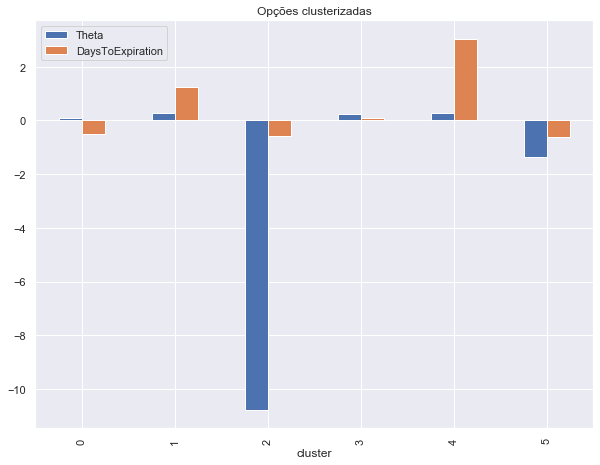

In [10]:
data_array = df_std.values
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=42)
df_std["cluster"] = kmeans.fit_predict(data_array)
df_std.groupby("cluster").aggregate("mean").plot.bar(figsize=(10,7.5))
plt.title("Opções clusterizadas")
plt.show()

O gráfico mostra que dentre os clusteres encontrados pelo modelo, há um que foge do comportamento padrão: o cluster 2.
Os registros agrupados nesse cluster serão definidos como anômalos.

## Definir label para anomalia

In [11]:
df_std['anomalia'] = 0
df_std.loc[df_std['cluster'] == 2, 'anomalia'] = 1

In [12]:
df_std.loc[(df_std['anomalia']) == 1].head(10)

,Theta,DaysToExpiration,cluster,anomalia
86,-7.927898,-0.578208,2,1
88,-11.200537,-0.578208,2,1
90,-13.072547,-0.578208,2,1
92,-12.974773,-0.578208,2,1
94,-11.133765,-0.578208,2,1
96,-8.257388,-0.578208,2,1


## Visualizando os clusteres formados

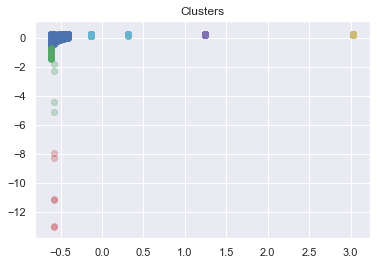

In [13]:
cor = ['b', 'g', 'r', 'c', 'm', 'y']

i=0
for cluster in df_std['cluster'].unique():
    df = df_std.loc[df_std['cluster'] == cluster]
    plt.scatter(df['DaysToExpiration'], df['Theta'], c=cor[i],alpha=0.3)
    i += 1
plt.title("Clusters")
plt.show()

## Visualizando o cluster anômalo

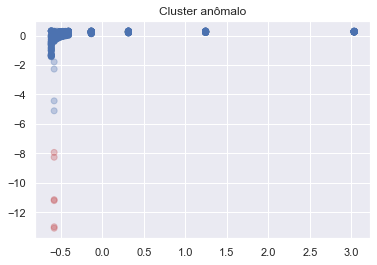

In [14]:
cor = []
for anomalia in df_std['anomalia'] :
    if anomalia == 1 :
        cor.append('r')
    else :
        cor.append('b')
plt.scatter(df_std['DaysToExpiration'], df_std['Theta'], c=cor,alpha=0.3)
plt.title("Cluster anômalo")
plt.show()

## Criando modelo de classificação

In [15]:
def particionaDados(X, Y, treinamento=.75, teste=.25, random_state=42):
    percentual_teste_validacao = 1 - treinamento
    X_treino, X_temp, Y_treino, Y_temp = train_test_split(X, Y, test_size=percentual_teste_validacao, 
        random_state=random_state)
    
    if(treinamento + teste < 1):
        validacao = 1 - (treinamento + teste)
        percentual_validacao = validacao / percentual_teste_validacao
        
        X_teste, X_validacao, Y_teste, Y_validacao = train_test_split(X_temp, Y_temp, test_size=percentual_validacao,
        random_state=random_state)
    else:
        X_teste = X_temp
        Y_teste = Y_temp
        X_validacao = []
        Y_validacao = [] 
   
    return (X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao)

In [16]:
def treinaKNN(k, p, X_treino, Y_treino, X_teste, Y_teste):
    classificador = KNeighborsClassifier(n_neighbors=k, p=p)
    classificador.fit(X_treino, Y_treino.ravel())

    y_pred = classificador.predict(X_teste)

    return (confusion_matrix(Y_teste, y_pred), accuracy_score(Y_teste, y_pred), classificador)

In [17]:
df_std.head()

,Theta,DaysToExpiration,cluster,anomalia
0,0.308149,-0.612607,0,0
1,-0.582944,-0.612607,0,0
2,0.308149,-0.612607,0,0
3,-0.609970,-0.612607,0,0
4,0.308149,-0.612607,0,0


In [18]:
X = df_std.iloc[:,0:2].values
Y = df_std.iloc[:,3:].values

X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao = particionaDados(X,Y,.75,.25)

len(df_std), len(X_treino), len(X_teste), len(X_validacao) , len(Y_treino), len(Y_teste), len(Y_validacao)

(858, 643, 215, 0, 643, 215, 0)

In [19]:
matrizes = {}
acuracias = {}
for k in [1,3,5,7]:
    treinamento = treinaKNN(k,2, X_treino, Y_treino, X_teste, Y_teste)
    matrizes[k] = treinamento[0]
    acuracias[k] = treinamento[1]

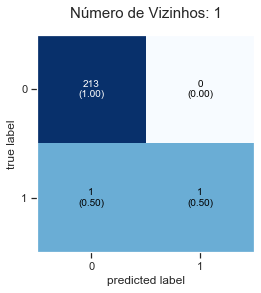

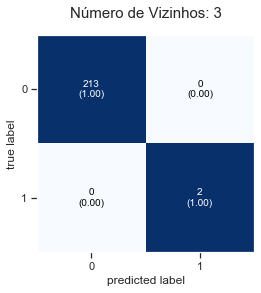

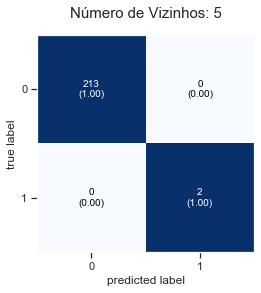

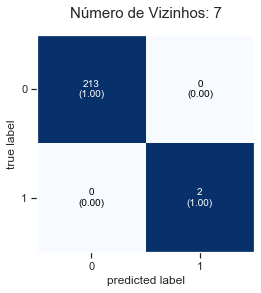

In [20]:
for k, matriz in matrizes.items(): 
    fig, ax = plot_confusion_matrix(conf_mat=matriz, show_absolute=True, show_normed=True)
    ax.set_title('Número de Vizinhos: ' + str(k), fontsize = 15)
    plt.show()

In [21]:
acuracias

{1: 0.9953488372093023, 3: 1.0, 5: 1.0, 7: 1.0}

## Identificando anomalia com o Isolation Forest

In [22]:
clf = IsolationForest(max_samples='auto', contamination=.025,\
                      n_estimators=10, \
                      random_state=19117, max_features=X.shape[1])
clf.fit(X)

y_pred = clf.predict(X)

D:\Programas\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


## Agregando a coluna de anomalia ao dataset original

In [23]:
df_std['cluster2'] = pd.DataFrame(data =y_pred,columns=['cluster2'])

In [24]:
df_std

,Theta,DaysToExpiration,cluster,anomalia,cluster2
0,0.308149,-0.612607,0,0,1
1,-0.582944,-0.612607,0,0,1
2,0.308149,-0.612607,0,0,1
3,-0.609970,-0.612607,0,0,1
4,0.308149,-0.612607,0,0,1
...,...,...,...,...,...
853,0.293443,3.033686,4,0,-1
854,0.286289,3.033686,4,0,1
855,0.297418,3.033686,4,0,-1
856,0.291058,3.033686,4,0,-1


Os registros com cluster2 = -1 são os identificados como anômalos

In [25]:
len(df_std.loc[df_std['cluster2'] == -1]), len(df_std.loc[df_std['cluster2'] == 1])

(22, 836)

Foram identificados 22 registros como anômalos

## Visualizando os registros anômalos

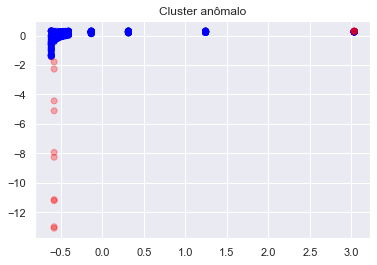

In [26]:
cor = []
for anomalia in df_std['cluster2'] :
    if anomalia == -1 :
        cor.append('red')
    else :
        cor.append('blue')
plt.scatter(df_std['DaysToExpiration'], df_std['Theta'], c=cor,alpha=0.3)
plt.title("Cluster anômalo")
plt.show()

In [27]:
df_std

,Theta,DaysToExpiration,cluster,anomalia,cluster2
0,0.308149,-0.612607,0,0,1
1,-0.582944,-0.612607,0,0,1
2,0.308149,-0.612607,0,0,1
3,-0.609970,-0.612607,0,0,1
4,0.308149,-0.612607,0,0,1
...,...,...,...,...,...
853,0.293443,3.033686,4,0,-1
854,0.286289,3.033686,4,0,1
855,0.297418,3.033686,4,0,-1
856,0.291058,3.033686,4,0,-1


## Criando modelo de classificação

In [28]:
X = df_std.iloc[:,0:2].values
Y = df_std.iloc[:,4:].values

X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao = particionaDados(X,Y,.75,.25)

len(df_std), len(X_treino), len(X_teste), len(X_validacao) , len(Y_treino), len(Y_teste), len(Y_validacao)

(858, 643, 215, 0, 643, 215, 0)

In [29]:
matrizes = {}
acuracias = {}
for k in [1,3,5,7]:
    treinamento = treinaKNN(k,2, X_treino, Y_treino, X_teste, Y_teste)
    matrizes[k] = treinamento[0]
    acuracias[k] = treinamento[1]

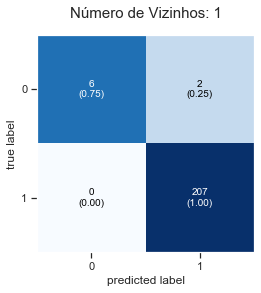

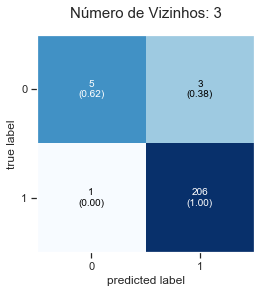

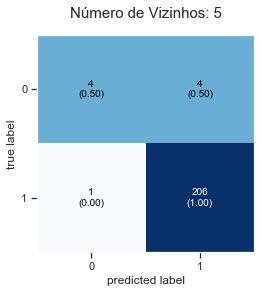

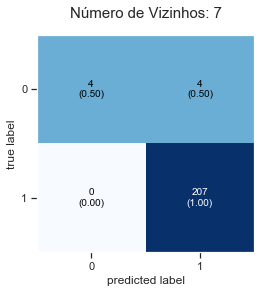

In [30]:
for k, matriz in matrizes.items(): 
    fig, ax = plot_confusion_matrix(conf_mat=matriz, show_absolute=True, show_normed=True)
    ax.set_title('Número de Vizinhos: ' + str(k), fontsize = 15)
    plt.show()

In [31]:
acuracias

{1: 0.9906976744186047,
 3: 0.9813953488372092,
 5: 0.9767441860465116,
 7: 0.9813953488372092}